## 1. Modelos forecaster por hora

### Objetivo

Determinación de los modelos de predicción de la demanda por hora de cada uno de los clúster de demanda.

### Descripción General de notebook

    1. Carga de datos bases 
    2. Agrupación de datos por clúster
    3. Feature engenier de las variables a incluir en los modelos
    4. Entrenamiento de los modelos
    5. Backtesting de cada uno de los modelos
    6. Evaluación de cada modelo

In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline
import seaborn as sns

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor


from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer

from joblib import dump, load

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [2]:
datos_final = pd.read_csv(".../.../Data/DataFrame_Final_Cierre_Cluster_FullFecha.csv",parse_dates=['FECHA'])

Agrupación de la demanda por Clúster, Año, Mes, Día, Hora, Temperatura, Dia de la semana, Es Festivo, Es fin de semana, AM_PM, Descripción del tiempo y resto de variables metereológiocas.

In [3]:
bicimad_def = datos_final.groupby(['CLUSTER_soloDemanda','ANIO','MES',
            'DIA','HORA','TEMPORADA','DIA_SEMANA', 'Es_Festivo', 
            'Es_FinSemana','AM_PM','DESC_TIEMPO','TEMPERATURA','HUMEDAD',
            'VIENTO','PRESION','PRECIPITACION_1h',
            'PRECIPITACION_3h']).agg(DEMANDA=('DEMANDA', 'sum'))
                                                                         
bicimad_def = bicimad_def.reset_index()

A continuación, se crea una variable fecha/hora denominada Fecha, las variables AM_PM, Mes, Día de la semana, Es Festivo y es Fin de semana se convierten en variables categóricas para después convertirlas en variables dummies.

Por otro lado la variable hora, se convierte en dos nuevas variables para determinar el seno y coseno de la misma y las variables Temperatura, Humedad, Viento, Presión, Precipitación 1h y 3h se realiza una transformación para estandarizarlas.

In [4]:
datos = datos_final

datos['FECHA'] =pd.to_datetime({'year': datos['ANIO'],
                                'month': datos["MES"],
                                'day': datos['DIA'],
                                'hour': datos['HORA'] },
                                 format='%d-%m-%Y', 
                                 errors='coerce')

datos['AM_PM'] = datos['AM_PM'].astype('category')
datos['MES']   = datos['MES'].astype('category')
datos['DIA_SEMANA'] = datos['DIA_SEMANA'].astype('category')
datos['Es_Festivo'] = datos['Es_Festivo'].astype('category')
datos['Es_FinSemana'] = datos['Es_FinSemana'].astype('category')

datos['hour_sin'] = np.sin(datos['HORA'] / 23 * 2 * np.pi)
datos['hour_cos'] = np.cos(datos['HORA'] / 23 * 2 * np.pi)

datos = pd.get_dummies(datos, columns=['AM_PM','TEMPORADA','DESC_TIEMPO',
        'MES','DIA_SEMANA','Es_Festivo','Es_FinSemana'], drop_first=True)

df_NumCols = datos[['TEMPERATURA','HUMEDAD','VIENTO','PRESION',
                    'PRECIPITACION_1h','PRECIPITACION_3h']]

scaler = StandardScaler()
datos[['TEMPERATURA','HUMEDAD','VIENTO','PRESION','PRECIPITACION_1h',
       'PRECIPITACION_3h']] = scaler.fit_transform(df_NumCols)

datos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3261120 entries, 0 to 3261119
Data columns (total 42 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   ESTACION                  int64         
 1   FECHA                     datetime64[ns]
 2   TEMPERATURA               float64       
 3   VIENTO                    float64       
 4   PRESION                   float64       
 5   HUMEDAD                   float64       
 6   PRECIPITACION_1h          float64       
 7   PRECIPITACION_3h          float64       
 8   DEMANDA                   int64         
 9   hour_sin                  float64       
 10  hour_cos                  float64       
 11  AM_PM_PM                  uint8         
 12  TEMPORADA_OTONO           uint8         
 13  TEMPORADA_PRIMAVERA       uint8         
 14  TEMPORADA_VERANO          uint8         
 15  DESC_TIEMPO_Clouds        uint8         
 16  DESC_TIEMPO_Drizzle       uint8         
 17  DESC_TIE

Una vez obtenido el conjunto de datos final, se procede a definir las variables exogenas que serán incluidas a los modelos

In [5]:

variables_exogenas = [column for column in datos.columns
                      if column.startswith(('AM_PM','TEMPORADA','DESC_TIEMPO',
                    'MES','DIA_SEMANA','Es_Festivo','Es_FinSemana'))]

variables_exogenas.extend(['TEMPERATURA', 'VIENTO', 'PRESION', 'HUMEDAD', 
                    'PRECIPITACION_1h','PRECIPITACION_3h', 'hour_sin','hour_cos'])

print(variables_exogenas)

['AM_PM_PM', 'TEMPORADA_OTONO', 'TEMPORADA_PRIMAVERA', 'TEMPORADA_VERANO', 'DESC_TIEMPO_Clouds', 'DESC_TIEMPO_Drizzle', 'DESC_TIEMPO_Fog', 'DESC_TIEMPO_Haze', 'DESC_TIEMPO_Mist', 'DESC_TIEMPO_Rain', 'DESC_TIEMPO_Snow', 'DESC_TIEMPO_Thunderstorm', 'MES_2', 'MES_3', 'MES_4', 'MES_5', 'MES_6', 'MES_7', 'MES_8', 'MES_9', 'MES_10', 'MES_11', 'MES_12', 'DIA_SEMANA_2', 'DIA_SEMANA_3', 'DIA_SEMANA_4', 'DIA_SEMANA_5', 'DIA_SEMANA_6', 'DIA_SEMANA_7', 'Es_Festivo_1', 'Es_FinSemana_1', 'TEMPERATURA', 'VIENTO', 'PRESION', 'HUMEDAD', 'PRECIPITACION_1h', 'PRECIPITACION_3h', 'hour_sin', 'hour_cos']


## Cluster 0

Para el entrenamiento de cada uno de los modelos se ha realizado lo siguiente:

 - Selección de los datos del clúster
 - Definir la variable Fecha como indice
 - Indicar que la frecuencia de los datos es por hora
 - Separar los datos de entrenamiento (01/03/2027 a 31/12/2019) y los datos de prueba (01/01/2020 a 29/02/2020)
 - Entrenar cada uno de los modelos utilizando la función ForecastAutoreg
 - Crear un backtesting forecaster para cada uno de los modelos
 - Determinar las métricas de los modelos (R2, MSE y RMSE)

In [6]:
datos_estaciones = datos[datos['CLUSTER_soloDemanda']==0]
datos_estaciones = datos_estaciones.drop_duplicates(subset = 'FECHA',keep='last')
datos_estaciones = datos_estaciones.drop(['CLUSTER_soloDemanda'], axis=1)
datos_estaciones = datos_estaciones.set_index('FECHA')
datos_estaciones = datos_estaciones.asfreq('60min')
datos_estaciones = datos_estaciones.sort_index()

datos_estaciones = datos_estaciones.loc[datos_estaciones.index.min(): datos_estaciones.index.max()]
fin_train = '2019-12-31 23:59:00'
fin_test = '2020-02-29 23:00:00'

datos_train = datos_estaciones.loc[: fin_train, :]
datos_test   = datos_estaciones.loc[fin_train:fin_test, :]


y_true = datos_test['DEMANDA']

forecaster_LGBM = ForecasterAutoreg(
        regressor = LGBMRegressor(random_state=123),
        lags = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72])

metrica_LGBM, predicciones_LGBM = backtesting_forecaster(
              forecaster = forecaster_LGBM,
              y = datos_estaciones.loc[:fin_test, 'DEMANDA'],
              exog = datos_estaciones.loc[:fin_test, variables_exogenas],    
              initial_train_size = int(len(datos_train)),
              fixed_train_size   = False,
              steps = 24,
              metric = 'mean_absolute_error',
              refit  = False,
              verbose = True)


score_LGBM = r2_score(y_true, predicciones_LGBM)
mse_LGBM = mean_squared_error(y_true, predicciones_LGBM)
rmse_LGBM = mse_LGBM**(0.5)


forecaster_XGB = ForecasterAutoreg(
        regressor = XGBRegressor(random_state=123),
        lags = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72])

metrica_XGB, predicciones_XGB = backtesting_forecaster(
               forecaster = forecaster_XGB,
               y = datos_estaciones.loc[:fin_test, 'DEMANDA'],
               exog = datos_estaciones.loc[:fin_test, variables_exogenas],    
               initial_train_size = int(len(datos_train)),
               fixed_train_size = False,
               steps = 24,
               metric = 'mean_absolute_error',
               refit = False,
               verbose = True)


score_XGB = r2_score(y_true, predicciones_XGB)
mse_XGB = mean_squared_error(y_true, predicciones_XGB)
rmse_XGB = mse_XGB**(0.5)


forecaster_RF = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state=123),
        lags = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72])

metrica_RF, predicciones_RF = backtesting_forecaster(
              forecaster = forecaster_RF,
              y = datos_estaciones.loc[:fin_test, 'DEMANDA'],
              exog = datos_estaciones.loc[:fin_test, variables_exogenas],    
              initial_train_size = int(len(datos_train)),
              fixed_train_size = False,
              steps = 24,
              metric = 'mean_absolute_error',
              refit = False,
              verbose = True)

score_RF = r2_score(y_true, predicciones_RF)
mse_RF = mean_squared_error(y_true, predicciones_RF)
rmse_RF = mse_RF**(0.5)


forecaster_GB = ForecasterAutoreg(
      regressor = GradientBoostingRegressor(random_state=123),
      lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72])

metrica_GB, predicciones_GB = backtesting_forecaster(
              forecaster = forecaster_GB,
              y = datos_estaciones.loc[:fin_test, 'DEMANDA'],
              exog = datos_estaciones.loc[:fin_test, variables_exogenas],    
              initial_train_size = int(len(datos_train)),
              fixed_train_size = False,
              steps = 24,
              metric = 'mean_absolute_error',
              refit = False,
              verbose = True)

score_GB = r2_score(y_true, predicciones_GB)
mse_GB = mean_squared_error(y_true, predicciones_GB)
rmse_GB = mse_GB**(0.5)

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

In [7]:
print('---------Evaluación del modelo RF---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_RF))
print("Mean Absolute Error: %.2f" % mse_RF)
print("Root Mean Squared Error: %.2f" % rmse_RF)
print('')

print('---------Evaluación del modelo LGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_LGBM))
print("Mean Absolute Error: %.2f" % mse_LGBM)
print("Root Mean Squared Error: %.2f" % rmse_LGBM)
print('')

print('---------Evaluación del modelo GB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_GB))
print("Mean Absolute Error: %.2f" % mse_GB)
print("Root Mean Squared Error: %.2f" % rmse_GB)
print('')

print('---------Evaluación del modelo XGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_XGB))
print("Mean Absolute Error: %.2f" % mse_XGB)
print("Root Mean Squared Error: %.2f" % rmse_XGB)
print('')

---------Evaluación del modelo RF---------------
R^2 Coefficient of Determination: 0.48.
Mean Absolute Error: 1.84
Root Mean Squared Error: 1.36

---------Evaluación del modelo LGB---------------
R^2 Coefficient of Determination: 0.49.
Mean Absolute Error: 1.80
Root Mean Squared Error: 1.34

---------Evaluación del modelo GB---------------
R^2 Coefficient of Determination: 0.50.
Mean Absolute Error: 1.76
Root Mean Squared Error: 1.33

---------Evaluación del modelo XGB---------------
R^2 Coefficient of Determination: 0.50.
Mean Absolute Error: 1.77
Root Mean Squared Error: 1.33



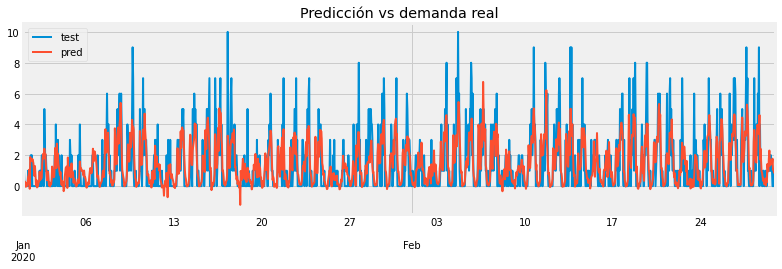

In [9]:
fig, ax = plt.subplots(figsize=(12, 3.5))
datos_estaciones.loc[predicciones_LGBM.index, 'DEMANDA'].plot(linewidth=2, label='test', ax=ax)
predicciones_XGB.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

## Cluster 1

In [10]:
datos_estaciones = datos[datos['CLUSTER_soloDemanda']==1]
datos_estaciones = datos_estaciones.drop_duplicates(subset = 'FECHA',keep='last')
datos_estaciones = datos_estaciones.drop(['CLUSTER_soloDemanda'], axis=1)
datos_estaciones = datos_estaciones.set_index('FECHA')
datos_estaciones = datos_estaciones.asfreq('60min')
datos_estaciones = datos_estaciones.sort_index()

datos_estaciones = datos_estaciones.loc[datos_estaciones.index.min(): datos_estaciones.index.max()]
fin_train = '2019-12-31 23:59:00'
fin_test = '2020-02-29 23:00:00'

datos_train = datos_estaciones.loc[: fin_train, :]
datos_test   = datos_estaciones.loc[fin_train:fin_test, :]

y_true = datos_test['DEMANDA']

forecaster_LGBM = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_LGBM, predicciones_LGBM = backtesting_forecaster(
                            forecaster = forecaster_LGBM,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_LGBM = r2_score(y_true, predicciones_LGBM)
mse_LGBM = mean_squared_error(y_true, predicciones_LGBM)
rmse_LGBM = mse_LGBM**(0.5)


forecaster_XGB = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_XGB, predicciones_XGB = backtesting_forecaster(
                            forecaster = forecaster_XGB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_XGB = r2_score(y_true, predicciones_XGB)
mse_XGB = mean_squared_error(y_true, predicciones_XGB)
rmse_XGB = mse_XGB**(0.5)


forecaster_RF = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_RF, predicciones_RF = backtesting_forecaster(
                            forecaster = forecaster_RF,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_RF = r2_score(y_true, predicciones_RF)
mse_RF = mean_squared_error(y_true, predicciones_RF)
rmse_RF = mse_RF**(0.5)


forecaster_GB = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_GB, predicciones_GB = backtesting_forecaster(
                            forecaster = forecaster_GB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_GB = r2_score(y_true, predicciones_GB)
mse_GB = mean_squared_error(y_true, predicciones_GB)
rmse_GB = mse_GB**(0.5)


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

In [11]:
print('---------Evaluación del modelo RF---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_RF ))
print("Mean Absolute Error: %.2f" % mse_RF)
print("Root Mean Squared Error: %.2f" % rmse_RF)
print('')

print('---------Evaluación del modelo LGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_LGBM))
print("Mean Absolute Error: %.2f" % mse_LGBM)
print("Root Mean Squared Error: %.2f" % rmse_LGBM)
print('')

print('---------Evaluación del modelo GB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_GB))
print("Mean Absolute Error: %.2f" % mse_GB)
print("Root Mean Squared Error: %.2f" % rmse_GB)
print('')

print('---------Evaluación del modelo XGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_XGB))
print("Mean Absolute Error: %.2f" % mse_XGB)
print("Root Mean Squared Error: %.2f" % rmse_XGB)
print('')

---------Evaluación del modelo RF---------------
R^2 Coefficient of Determination: 0.39.
Mean Absolute Error: 4.54
Root Mean Squared Error: 2.13

---------Evaluación del modelo LGB---------------
R^2 Coefficient of Determination: 0.40.
Mean Absolute Error: 4.51
Root Mean Squared Error: 2.12

---------Evaluación del modelo GB---------------
R^2 Coefficient of Determination: 0.29.
Mean Absolute Error: 5.34
Root Mean Squared Error: 2.31

---------Evaluación del modelo XGB---------------
R^2 Coefficient of Determination: 0.32.
Mean Absolute Error: 5.08
Root Mean Squared Error: 2.25



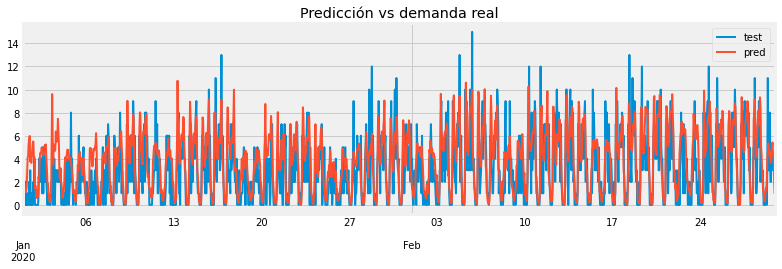

In [12]:
fig, ax = plt.subplots(figsize=(12, 3.5))
datos_estaciones.loc[predicciones_XGB.index, 'DEMANDA'].plot(linewidth=2, label='test', ax=ax)
predicciones_RF.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

## Cluster 2

In [13]:
datos_estaciones = datos[datos['CLUSTER_soloDemanda']==2]
datos_estaciones = datos_estaciones.drop_duplicates(subset = 'FECHA',keep='last')
datos_estaciones = datos_estaciones.drop(['CLUSTER_soloDemanda'], axis=1)
datos_estaciones = datos_estaciones.set_index('FECHA')
datos_estaciones = datos_estaciones.asfreq('60min')
datos_estaciones = datos_estaciones.sort_index()

datos_estaciones = datos_estaciones.loc[datos_estaciones.index.min(): datos_estaciones.index.max()]
fin_train = '2019-12-31 23:59:00'
fin_test = '2020-02-29 23:00:00'

datos_train = datos_estaciones.loc[: fin_train, :]
datos_test   = datos_estaciones.loc[fin_train:fin_test, :]

y_true = datos_test['DEMANDA']

forecaster_LGBM = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_LGBM, predicciones_LGBM = backtesting_forecaster(
                            forecaster = forecaster_LGBM,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_LGBM = r2_score(y_true, predicciones_LGBM)
mse_LGBM = mean_squared_error(y_true, predicciones_LGBM)
rmse_LGBM = mse_LGBM**(0.5)


forecaster_XGB = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_XGB, predicciones_XGB = backtesting_forecaster(
                            forecaster = forecaster_XGB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_XGB = r2_score(y_true, predicciones_XGB)
mse_XGB = mean_squared_error(y_true, predicciones_XGB)
rmse_XGB = mse_XGB**(0.5)


forecaster_RF = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_RF, predicciones_RF = backtesting_forecaster(
                            forecaster = forecaster_RF,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_RF = r2_score(y_true, predicciones_RF)
mse_RF = mean_squared_error(y_true, predicciones_RF)
rmse_RF = mse_RF**(0.5)


forecaster_GB = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_GB, predicciones_GB = backtesting_forecaster(
                            forecaster = forecaster_GB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_GB = r2_score(y_true, predicciones_GB)
mse_GB = mean_squared_error(y_true, predicciones_GB)
rmse_GB = mse_GB**(0.5)


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

In [14]:
print('---------Evaluación del modelo RF---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_RF ))
print("Mean Absolute Error: %.2f" % mse_RF)
print("Root Mean Squared Error: %.2f" % rmse_RF)
print('')

print('---------Evaluación del modelo LGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_LGBM))
print("Mean Absolute Error: %.2f" % mse_LGBM)
print("Root Mean Squared Error: %.2f" % rmse_LGBM)
print('')

print('---------Evaluación del modelo GB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_GB))
print("Mean Absolute Error: %.2f" % mse_GB)
print("Root Mean Squared Error: %.2f" % rmse_GB)
print('')

print('---------Evaluación del modelo XGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_XGB))
print("Mean Absolute Error: %.2f" % mse_XGB)
print("Root Mean Squared Error: %.2f" % rmse_XGB)
print('')

---------Evaluación del modelo RF---------------
R^2 Coefficient of Determination: 0.34.
Mean Absolute Error: 2.45
Root Mean Squared Error: 1.56

---------Evaluación del modelo LGB---------------
R^2 Coefficient of Determination: 0.32.
Mean Absolute Error: 2.52
Root Mean Squared Error: 1.59

---------Evaluación del modelo GB---------------
R^2 Coefficient of Determination: 0.29.
Mean Absolute Error: 2.62
Root Mean Squared Error: 1.62

---------Evaluación del modelo XGB---------------
R^2 Coefficient of Determination: 0.28.
Mean Absolute Error: 2.63
Root Mean Squared Error: 1.62



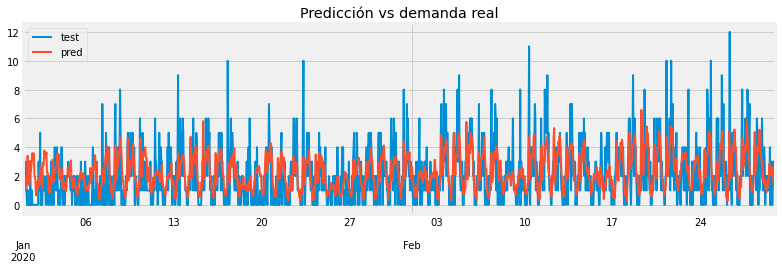

In [15]:
fig, ax = plt.subplots(figsize=(12, 3.5))
datos_estaciones.loc[predicciones_RF.index, 'DEMANDA'].plot(linewidth=2, label='test', ax=ax)
predicciones_RF.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

## Cluster 3

In [16]:
datos_estaciones = datos[datos['CLUSTER_soloDemanda']==3]
datos_estaciones = datos_estaciones.drop_duplicates(subset = 'FECHA',keep='last')
datos_estaciones = datos_estaciones.drop(['CLUSTER_soloDemanda'], axis=1)
datos_estaciones = datos_estaciones.set_index('FECHA')
datos_estaciones = datos_estaciones.asfreq('60min')
datos_estaciones = datos_estaciones.sort_index()

datos_estaciones = datos_estaciones.loc[datos_estaciones.index.min(): datos_estaciones.index.max()]
fin_train = '2019-12-31 23:59:00'
fin_test = '2020-02-29 23:00:00'

datos_train = datos_estaciones.loc[: fin_train, :]
datos_test   = datos_estaciones.loc[fin_train:fin_test, :]

y_true = datos_test['DEMANDA']

forecaster_LGBM = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_LGBM, predicciones_LGBM = backtesting_forecaster(
                            forecaster = forecaster_LGBM,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_LGBM = r2_score(y_true, predicciones_LGBM)
mse_LGBM = mean_squared_error(y_true, predicciones_LGBM)
rmse_LGBM = mse_LGBM**(0.5)


forecaster_XGB = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_XGB, predicciones_XGB = backtesting_forecaster(
                            forecaster = forecaster_XGB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_XGB = r2_score(y_true, predicciones_XGB)
mse_XGB = mean_squared_error(y_true, predicciones_XGB)
rmse_XGB = mse_XGB**(0.5)


forecaster_RF = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_RF, predicciones_RF = backtesting_forecaster(
                            forecaster = forecaster_GB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_RF = r2_score(y_true, predicciones_RF)
mse_RF = mean_squared_error(y_true, predicciones_RF)
rmse_RF = mse_RF**(0.5)


forecaster_GB = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_GB, predicciones_GB = backtesting_forecaster(
                            forecaster = forecaster_RF,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_GB = r2_score(y_true, predicciones_GB)
mse_GB = mean_squared_error(y_true, predicciones_GB)
rmse_GB = mse_GB**(0.5)


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

In [17]:
print('---------Evaluación del modelo RF---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_RF ))
print("Mean Absolute Error: %.2f" % mse_RF)
print("Root Mean Squared Error: %.2f" % rmse_RF)
print('')

print('---------Evaluación del modelo LGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_LGBM))
print("Mean Absolute Error: %.2f" % mse_LGBM)
print("Root Mean Squared Error: %.2f" % rmse_LGBM)
print('')

print('---------Evaluación del modelo GB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_GB))
print("Mean Absolute Error: %.2f" % mse_GB)
print("Root Mean Squared Error: %.2f" % rmse_GB)
print('')

print('---------Evaluación del modelo XGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_XGB))
print("Mean Absolute Error: %.2f" % mse_XGB)
print("Root Mean Squared Error: %.2f" % rmse_XGB)
print('')

---------Evaluación del modelo RF---------------
R^2 Coefficient of Determination: 0.59.
Mean Absolute Error: 6.23
Root Mean Squared Error: 2.50

---------Evaluación del modelo LGB---------------
R^2 Coefficient of Determination: 0.63.
Mean Absolute Error: 5.63
Root Mean Squared Error: 2.37

---------Evaluación del modelo GB---------------
R^2 Coefficient of Determination: 0.61.
Mean Absolute Error: 6.00
Root Mean Squared Error: 2.45

---------Evaluación del modelo XGB---------------
R^2 Coefficient of Determination: 0.61.
Mean Absolute Error: 6.01
Root Mean Squared Error: 2.45



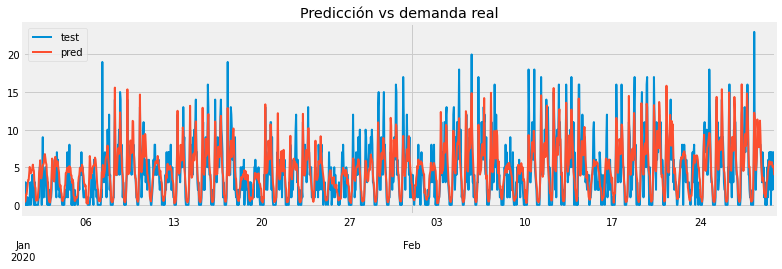

In [18]:
fig, ax = plt.subplots(figsize=(12, 3.5))
datos_estaciones.loc[predicciones_LGBM.index, 'DEMANDA'].plot(linewidth=2, label='test', ax=ax)
predicciones_LGBM.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

## Cluster 4

In [19]:
datos_estaciones = datos[datos['CLUSTER_soloDemanda']==4]
datos_estaciones = datos_estaciones.drop_duplicates(subset = 'FECHA',keep='last')
datos_estaciones = datos_estaciones.drop(['CLUSTER_soloDemanda'], axis=1)
datos_estaciones = datos_estaciones.set_index('FECHA')
datos_estaciones = datos_estaciones.asfreq('60min')
datos_estaciones = datos_estaciones.sort_index()

datos_estaciones = datos_estaciones.loc[datos_estaciones.index.min(): datos_estaciones.index.max()]
fin_train = '2019-12-31 23:59:00'
fin_test = '2020-02-29 23:00:00'

datos_train = datos_estaciones.loc[: fin_train, :]
datos_test   = datos_estaciones.loc[fin_train:fin_test, :]

y_true = datos_test['DEMANDA']

forecaster_LGBM = ForecasterAutoreg(
                regressor = LGBMRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_LGBM, predicciones_LGBM = backtesting_forecaster(
                            forecaster = forecaster_LGBM,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_LGBM = r2_score(y_true, predicciones_LGBM)
mse_LGBM = mean_squared_error(y_true, predicciones_LGBM)
rmse_LGBM = mse_LGBM**(0.5)


forecaster_XGB = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_XGB, predicciones_XGB = backtesting_forecaster(
                            forecaster = forecaster_XGB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )


score_XGB = r2_score(y_true, predicciones_XGB)
mse_XGB = mean_squared_error(y_true, predicciones_XGB)
rmse_XGB = mse_XGB**(0.5)


forecaster_RF = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_RF, predicciones_RF = backtesting_forecaster(
                            forecaster = forecaster_RF,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_RF = r2_score(y_true, predicciones_RF)
mse_RF = mean_squared_error(y_true, predicciones_RF)
rmse_RF = mse_RF**(0.5)


forecaster_GB = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(random_state=123),
                lags      = [1,2,3,4,5,6,7,8,9,10,11,12, 24, 48, 72]
             )

metrica_GB, predicciones_GB = backtesting_forecaster(
                            forecaster = forecaster_GB,
                            y          = datos_estaciones.loc[:fin_test, 'DEMANDA'],
                            exog       = datos_estaciones.loc[:fin_test, variables_exogenas],    
                            initial_train_size = int(len(datos_train)),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True
                        )

score_GB = r2_score(y_true, predicciones_GB)
mse_GB = mean_squared_error(y_true, predicciones_GB)
rmse_GB = mse_GB**(0.5)


Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

Information of backtesting process
----------------------------------
Number of observations used for initial training or as initial window: 17520
Number of observations used for backtesting: 1440
    Number of folds: 60
    Number of steps per fold: 24

Data partition in fold: 0
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-01 00:00:00 -- 2020-01-01 23:00:00
Data partition in fold: 1
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-02 00:00:00 -- 2020-01-02 23:00:00
Data partition in fold: 2
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-03 00:00:00 -- 2020-01-03 23:00:00
Data partition in fold: 3
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-04 00:00:00 -- 2020-01-04 23:00:00
Data partition in fold: 4
    Training:   2018-01-01 00:00:00 -- 2019-12-31 23:00:00
    Validation: 2020-01-05 00:00:00 -- 2020-01-05 23:00:00
Data partition in fold: 5

In [20]:
print('---------Evaluación del modelo RF---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_RF ))
print("Mean Absolute Error: %.2f" % mse_RF)
print("Root Mean Squared Error: %.2f" % rmse_RF)
print('')

print('---------Evaluación del modelo LGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_LGBM))
print("Mean Absolute Error: %.2f" % mse_LGBM)
print("Root Mean Squared Error: %.2f" % rmse_LGBM)
print('')

print('---------Evaluación del modelo GB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_GB))
print("Mean Absolute Error: %.2f" % mse_GB)
print("Root Mean Squared Error: %.2f" % rmse_GB)
print('')

print('---------Evaluación del modelo XGB---------------')
print('R^2 Coefficient of Determination: {:0.2f}.'.format(score_XGB))
print("Mean Absolute Error: %.2f" % mse_XGB)
print("Root Mean Squared Error: %.2f" % rmse_XGB)
print('')

---------Evaluación del modelo RF---------------
R^2 Coefficient of Determination: 0.67.
Mean Absolute Error: 3.58
Root Mean Squared Error: 1.89

---------Evaluación del modelo LGB---------------
R^2 Coefficient of Determination: 0.67.
Mean Absolute Error: 3.51
Root Mean Squared Error: 1.87

---------Evaluación del modelo GB---------------
R^2 Coefficient of Determination: 0.65.
Mean Absolute Error: 3.80
Root Mean Squared Error: 1.95

---------Evaluación del modelo XGB---------------
R^2 Coefficient of Determination: 0.64.
Mean Absolute Error: 3.83
Root Mean Squared Error: 1.96



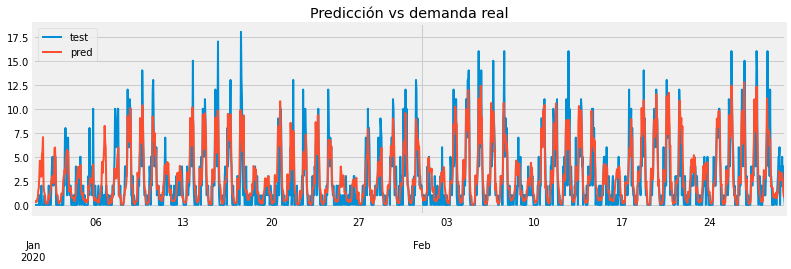

In [21]:
fig, ax = plt.subplots(figsize=(12, 3.5))
datos_estaciones.loc[predicciones_RF.index, 'DEMANDA'].plot(linewidth=2, label='test', ax=ax)
predicciones_RF.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();